# Neural Network Take 2

- Build a fully connected neural network with 2 hidden layers

<center><img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/></center>

- Using TensorFlow's higher-level operations and functions

## Estimators 

- High level TensorFlow API that encapsulates
    - Training
    - Testing
    - Prediction
    - Export for model serving

- Two kinds of estimators
    - Pre-made built-in estimators: DNNClassifier, LinearRegressor
    - Custom estimators: written using Estimator API

<center><img src="../../resources/img/estimator_types.png" alt="nn" style="width: 400px;"/></center>

### Benefits of estimators

- Estimator-based models are independent of operating environment
    - local host
    - GPUs
    - CPU clusters

- Simplify model sharing between deveopers

- State of the art models with high-level intuitive code

- Built using tf.layers
- Estimators build TF Graph automatically given a series of layers

Please go through https://www.tensorflow.org/programmers_guide/estimators for more advantages of using Estimators as described by the developers of TensorFlow.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

In [7]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Using the same parameters as when we built the neural network using the low-level TF API

In [2]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

## Using the Estimator API 

### Create an `input function`

   * Supplies data for training, evaluation, prediction
   * Yields tuples of:
        - Python dict `features`: key = name of feature, value = array of feature values
        - Array `label` : label for every example

How the `input function` generates the `features` and `label` is up to the developer. TensorFlow developers recommend the use of the  TensorFlow's Dataset API. The Dataset API can parse in all kinds of data using a high level specification. This includes:
- reading lines from a file
- reading records from binary files
- iterators
- Initialize Dataset from  in-memory data

The Dataset API can even read in large files in parallel and join them into a single stream. It is highly versatile and should definitely be used when training from data that resides on the disk. 
For more information, refer: https://www.tensorflow.org/get_started/datasets_quickstart

To define our input function, we will use an inbuilt function `tf.estimator.inputs.numpy_input_fn` which can take in Numpy arrays and returns an input function.

From the documentation:

>Returns input function that would feed dict of numpy arrays into the model.
This returns a function outputting features and targets based on the dict of numpy arrays. The dict features has the same keys as the x. The dict targets has the same keys as the y if y is a dict.

In [11]:
def get_input_fn(mode):
    if mode == 'train':
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.train.images}, y=mnist.train.labels,
            batch_size=batch_size, num_epochs=None, shuffle=True)
    elif mode == "evaluation":
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.test.images}, y=mnist.test.labels,
            batch_size=batch_size, shuffle=False)

### Create Feature Columns

    If we had read the data from files, we need to create feature columns that describe how to use the input. 
    
    Is it numeric? Categorical? 

### Define the Model Function 

- Model function is the beating heart of Estimator

- Has the following signature:
```
def my_model_fn(
       features, # This is batch_features from input_fn
       labels,   # This is batch_labels from input_fn
       mode,     # An instance of tf.estimator.ModeKeys
       params):  # Additional configuration
```

ModeKeys specify whether the model is being called for training, evaluation or prediction. This is useful for neural network architectures that vary between training and prediction, such as for models that make use of dropout.

**Workflow**:

- Define the model

- Specify additional calculations for:
    - Training
    - Prediction
    - Evaluation

Defining a neural network function to use later
- Input: feature dict
- Output: Array of 10 logits 

When using the Estimator API, it is recommended to use mid-level APIs such as Layers and Metrics in order to simplify the specification of our model. Fully connected hidden layers are implemented in `tf.layers` as a `Dense` layer. The Dense layer takes as input an incoming tensor, and the number of nodes in the Dense layer that we are specifying. 

In [5]:
def neural_net(x_dict):
    x = x_dict['images']
    layer_1 = tf.layers.dense(x, n_hidden_1)
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

Benefits of high level API:
- Can encapsulate calculations as pre-defined layers. Other layers include:
    - Convolution, Dropout, Pooling

In [4]:
# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

### Implementing the Model function

First, prepare the output and predictions

```
logits = neural_net(features)
pred_classes = tf.argmax(logits, axis=1)
pred_probabilties = tf.nn.softmax(logits)
```

The model function returns an instance of `tf.estimator.EstimatorSpec`
```
class EstimatorSpec(
    collections.namedtuple('EstimatorSpec', [
        'mode', 'predictions', 'loss', 'train_op', 'eval_metric_ops',
        'export_outputs', 'training_chief_hooks', 'training_hooks', 'scaffold',
        'evaluation_hooks'
    ])):
```

If we are only interested in prediction or inference from the neural network, we do not need to backpropagate errors. In fact, we would not have the actual labels to calculate errors. 

In this case, we do not require the backpropagation part of the TF Graph. We can return an EstimatorSpec as soon as we make our predictions. 

For more complex DNN's there may be different model architectures for training as compared to evaluation or prediction. It is important to fully account for these cases in the specification of our model function by handling the branching cases. An example of a more complex DNN is a DNN that uses dropout layers.

**Handle branching cases**

- Prediction
```
if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
```

- Training and Evaluation

```
estim_specs = tf.estimator.EstimatorSpec(
  mode=mode,
  predictions=pred_classes,
  loss=loss_op,
  train_op=train_op,
  eval_metric_ops={'accuracy': acc_op})

return estim_specs
```


In [6]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

### Build and Use the Estimator


In [7]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_is_chief': True, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'D:\\Temp\\tmpxvj6xfyw', '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002EF9D924908>, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_task_id': 0, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker'}


### Train the Model
 

The model can be trained using the Estimator's `train` function

In [10]:
input_fn = get_input_fn('train')
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into D:\Temp\tmpxvj6xfyw\model.ckpt.
INFO:tensorflow:step = 1, loss = 2.4518557
INFO:tensorflow:global_step/sec: 99.4813
INFO:tensorflow:step = 101, loss = 0.33296615 (1.008 sec)
INFO:tensorflow:global_step/sec: 100.966
INFO:tensorflow:step = 201, loss = 0.36804593 (0.990 sec)
INFO:tensorflow:global_step/sec: 111.652
INFO:tensorflow:step = 301, loss = 0.3458166 (0.896 sec)
INFO:tensorflow:global_step/sec: 104.528
INFO:tensorflow:step = 401, loss = 0.12781583 (0.957 sec)
INFO:tensorflow:global_step/sec: 114.074
INFO:tensorflow:step = 501, loss = 0.33862978 (0.877 sec)
INFO:tensorflow:global_step/sec: 111.84
INFO:tensorflow:step = 601, loss = 0.301341 (0.894 sec)
INFO:tensorflow:global_step/sec: 108.889
INFO:tensorflow:step = 701, loss = 0.3442419 (0.918 sec)
INFO:tensorflow:global_step/sec: 112.168
INFO:tensorflow:step = 801, loss = 0.33781174 (0.892 sec)
INFO:tensorflow:global_step/sec: 108.845
INFO:te

### Evaluate the Model

The model can be trained using the Estimator's `evaluate` function

Remember, we need the evaluation input function when we test our model

In [14]:
evaluate_input_fn = get_input_fn('evaluation')
model.evaluate(evaluate_input_fn)

INFO:tensorflow:Starting evaluation at 2018-02-23-06:23:20
INFO:tensorflow:Restoring parameters from D:\Temp\tmpxvj6xfyw\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-02-23-06:23:21
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9181, global_step = 1000, loss = 0.2829952


{'accuracy': 0.9181, 'global_step': 1000, 'loss': 0.2829952}

### Predict using the Model 

INFO:tensorflow:Restoring parameters from D:\Temp\tmpxvj6xfyw\model.ckpt-1000
Model predictions are  [7, 2]
Model predictions are  [1, 0]


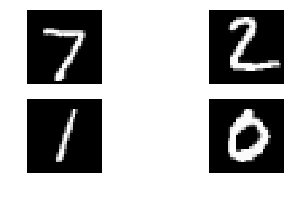

In [27]:
n_images = 4

actual_labels = mnist.test.images[:n_images]
predictions = list(model.predict(evaluate_input_fn))

# Display
f = plt.figure(figsize=(6,3))
for i in range(n_images):
    sp = f.add_subplot(2, 2, i+1)
    sp.axis('Off')
    plt.imshow(np.reshape(actual_labels[i], [28, 28]), cmap='gray')
print('Model predictions are ' ,predictions[:2])
print('Model predictions are ' ,predictions[2:4])

# Convolutional Neural Networks Using Estimators 

<center>![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)</center>

Parameters for our CNN

In [4]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

## Strategy

**Step 1** - Implement a ConvNet function using Layers API

**Step 2** - Define model in terms of ConvNet function and input_fn


**Step 3** - Build Estimator

**Step 4** - Train, Evaluate, Predict

 ## ConvNet Function

Input: 
- x_dict -- dict
- n_classes -- int
- dropout -- boolean
- reuse -- boolean
- is_training -- boolean

Output: logits -- array of `n_classes` logits

<font color="blue">What is dropout?</font>

Dropout is a technique developed in 2014 to "learn better by learning less". A dropout layer between two Dense layers would not permit the forward or backward flow of information with a pre-defined probability at training time. In other words, Dropout randomly drops neural units in the layers that sandwich the Dropout layer during training. The learned wisdom behind Dropout is that it aids in regularization by forcing the Neural network to learn without overfitting.

### Dropout 

- Randomly drop neurons in layers surrounding a dropout layer when training

- Aids in regularization by forcing NN to learn without overfitting

<center><img src="../../resources/img/Dropout.png" alt="nn" style="width: 400px;"/>
Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014</center>

**Testing with Dropout**:

- Use all neurons

- Different DataFlow Graph for Training and Testing

- Retain all weights learned during Training 

- Inbuilt TensorFlow support for Dropout -- `reuse` flag in `variable_scope`:
```
with tf.variable_scope('ConvNet', reuse=reuse):
```

At test time, all neurons in the network are active. So the computational graph varies between the training and testing phase, however the weights applied at each neuron remain the same. 

TensorFlow provides support to maintain the weights between computational graphs using a `reuse` flag when we enclose a Graph in a predefined scope.
```
with tf.variable_scope('ConvNet', reuse=reuse):
```

- Resize Input to match picture format
- Picture format = 28 x 28, 1 channel

```x = tf.reshape(x, shape=[-1, 28, 28, 1])```

Our input tensor has the shape `784 x batch_size`.

We should reshape the input tensor so that the ConvNet can learn filters that are spatially aware. We'll reshape this input tensor to match the picture's format: `Height x Width x Channel`.

```x = tf.reshape(x, shape=[-1, 28, 28, 1])```
 
Tensor input is now 4-D: `Batch Size, Height, Width, Channel`



### Convolution and Pooling

<center><img src="../../resources/img/ConvNet_Layers.png" alt="nn" style="width: 600px;"/>

**2D Convolution**

- Element wise multiplication of 2D filter as it slides across the length and breadth of input image  

```
conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
```

**2D Max Pooling**

- Reduce the spatial size of input by subsampling every `n x n` slice of a Convolved 2D Tensor 
- Replace each slice with max value in the slice

```
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
```

ConvNets are built using the fundamental operations of Convolution and Pooling.

The 2D Convolution operation takes a large input 2D Tensor and multiplies each element, the weight, in a smaller 2D window, canonically called the Convolutional Filter.

The Pooling operation's function is to reduce the spatial size of the input image, reducing the number of parameters and avoiding overfitting. The most commonly used Pooling operation for images is a 2D MAX Pooling operation that downsamples every `n x n` slice of the Convolved Tensor by replacing the slice with the Maximum value in the `n x n` slice.

For a more detailed, but probably the clearest writing about ConvNets, check out Andrej Karpathy's CSE231n lesson notes about the layers in ConvNets: http://cs231n.github.io/convolutional-networks/#pool   

TensorFlow provides support for Convolution and Pooling through the Layers API

- Convolution:
```
conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
```
Specifies a Convolutional layer with 32 filters, and shape `5 x 5`

- Pooling:
```
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
```
Specifies a Max Pooling layer with a stride of 2, and shape `2 x 2`

Next, we need to flatten the convolved and downsampled image into a 1 dimensional Tensor so that we can pass it through Dense layers and output an array of 10 logits.

```
fc1 = tf.contrib.layers.flatten(conv2)
```

Lastly, we add Dense layers that sandwich a Dropout layer
```
fc1 = tf.layers.dense(fc1, 1024)
fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
out = tf.layers.dense(fc1, n_classes)
```

The `training` flag in the Dropout layer is a toggle to enable the layer when we are Training the model, and disable it at test time.

Putting it all together,

In [8]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input becomes 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer 2 with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

## Model Function

Our model function is very similar to the model function we wrote for the simple feed-forward Neural Network. Except that we use the ConvNet function to get our logits.

We also need to call the ConvNet function in two different ways because Dropout has different behavior at training and testing time:
- Training:
`logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)`

- Testing:
`logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)`


In [14]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

## Build the Estimator

In [15]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_num_ps_replicas': 0, '_tf_random_seed': None, '_service': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023999646FD0>, '_session_config': None, '_save_checkpoints_steps': None, '_model_dir': 'D:\\Temp\\tmpkht_pku2', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_task_type': 'worker', '_save_summary_steps': 100, '_master': ''}


## Training

We still need an input function. Our input function is actually the same as when we built a feedforward neural network. This is the thing about the Estimator API. It makes the model independent of the input data.

In [16]:
input_fn = get_input_fn('train')

In [17]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into D:\Temp\tmpkht_pku2\model.ckpt.
INFO:tensorflow:loss = 2.3265784, step = 1
INFO:tensorflow:global_step/sec: 4.41244
INFO:tensorflow:loss = 0.0964202, step = 101 (22.666 sec)
INFO:tensorflow:global_step/sec: 4.2523
INFO:tensorflow:loss = 0.09626232, step = 201 (23.517 sec)
INFO:tensorflow:global_step/sec: 4.39865
INFO:tensorflow:loss = 0.032961518, step = 301 (22.734 sec)
INFO:tensorflow:global_step/sec: 4.01977
INFO:tensorflow:loss = 0.23971115, step = 401 (24.879 sec)
INFO:tensorflow:global_step/sec: 4.17903
INFO:tensorflow:loss = 0.053734824, step = 501 (23.933 sec)
INFO:tensorflow:global_step/sec: 4.0423
INFO:tensorflow:loss = 0.035259385, step = 601 (24.733 sec)
INFO:tensorflow:global_step/sec: 4.21675
INFO:tensorflow:loss = 0.02497337, step = 701 (23.716 sec)
INFO:tensorflow:global_step/sec: 4.4661
INFO:tensorflow:loss = 0.028952029, step = 801 (22.390 sec)
INFO:tensorflow:global_step/sec: 4.

## Evaluation 

In [18]:
input_fn = get_input_fn('evaluation')

In [19]:
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-02-23-19:34:26
INFO:tensorflow:Restoring parameters from D:\Temp\tmpkht_pku2\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-02-23-19:34:33
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9919, global_step = 2000, loss = 0.028276833


{'accuracy': 0.9919, 'global_step': 2000, 'loss': 0.028276833}

## Prediction

In [28]:
import random

INFO:tensorflow:Restoring parameters from D:\Temp\tmpkht_pku2\model.ckpt-2000
Model predictions are  [1, 3]
Model predictions are  [1, 5]


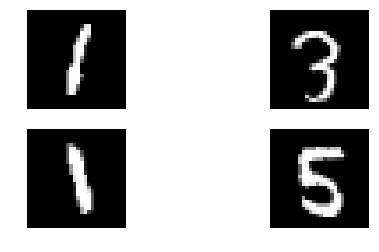

In [29]:
n_images = 4
offset = random.randint(0, 10000)
actual_labels = mnist.test.images[offset:offset + n_images]
predictions = list(model.predict(input_fn))[offset: offset + n_images]

# Display
f = plt.figure(figsize=(8,4))
for i in range(n_images):
    sp = f.add_subplot(2, 2, i+1)
    sp.axis('Off')
    plt.imshow(np.reshape(actual_labels[i], [28, 28]), cmap='gray')
print('Model predictions are ' ,predictions[:2])
print('Model predictions are ' ,predictions[2:4])